## Importing and Processing Data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from keras import regularizers
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder # one-hot encoding for age

from PIL import Image
import os

In [2]:
path="../dataset/face_age/"


In [3]:
#Visualization of images

# def visualize_image(age, number_of_images):
#     plt.figure(figsize=(10, 10))
#     folder=path+age+'/'
#     images=os.listdir(folder)[:number_of_images]
#     for i in range(number_of_images):
#         img=mpimg.imread(folder+images[i])
#         plt.subplot(number_of_images/2, 2, i+1)
#         plt.imshow(img)

# visualize_image("020", 10)

In [4]:
# X=[]
# y=[]

# for folder, _, imgs in os.walk(path):
#     if folder!="face_age":
#         for img in imgs:
#             img_path=folder+'/'+img
#             image=Image.open(img_path)
#             image=image.convert('RGB')
#             X.append(np.array(image))
#             y.append(int(folder[-3:]))

# X=np.array(X)
# y=np.array(y);

In [5]:
# X=X.astype("float32")
# #normalization
# X/=255.0
# X

In [6]:
# X.shape

In [7]:
# os.mkdir("../dataset/Data")

In [41]:
# np.save("../dataset/face_age_data/X.npy", X)
# np.save("../dataset/face_age_data/y.npy", y)
X = np.load('../dataset/face_age_data/X.npy')
y = np.load('../dataset/face_age_data/y.npy')

## Train, Test and Validation Datasets

In [42]:
# Train, validation and testing split (70/15/15)

# test_size = 0.3
# seed = 0
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=True, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [43]:
# save to files
# np.save('../dataset/face_age_data/X_train.npy', X_train)
# np.save('../dataset/face_age_data/y_train.npy', y_train)
# np.save('../dataset/face_age_data/X_val.npy', X_val)
# np.save('../dataset/face_age_data/y_val.npy', y_val)
# np.save('../dataset/face_age_data/X_test.npy', X_test)
# np.save('../dataset/face_age_data/y_test.npy', y_test)

X_train = np.load('../dataset/face_age_data/X_train.npy')
y_train = np.load('../dataset/face_age_data/y_train.npy')
X_val = np.load('../dataset/face_age_data/X_val.npy')
y_val = np.load('../dataset/face_age_data/y_val.npy')
X_test = np.load('../dataset/face_age_data/X_test.npy')
y_test = np.load('../dataset/face_age_data/y_test.npy')

In [11]:
# confirm the saved files
# os.listdir("../face_age_dataset/Data")

## Image Augmentation

In [12]:
# Apply Image Augmentation

train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2, 
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

## Callbacks and Default Hyperparameters

In [13]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't increase (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

        
# hyperparameters
lr = 0.01
epochs = 50
batch_size = 128
results = {}
input_shape =[200, 200]
num_of_ages = 100

## Simple CNN Model

* A simple CNN model with 6 layers:
Input - Conv - MaxPool - Dropout - Flatten - Output

In [14]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",
                   padding="valid",
                   kernel_regularizer=regularizers.l2(0.00001),
                   input_shape=(input_shape[0], input_shape[1], 3)))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1,activation="linear")) 
    return model

In [15]:
Adam= keras.optimizers.Adam(lr=0.1,beta_1=0.9, beta_2=0.999, decay=0.0)

In [16]:
model = baseline_model()

model.compile(optimizer="adam",loss="mean_absolute_error",metrics=['mean_absolute_error'])

model_history = model.fit_generator(
            train_datagen.flow(X_train,y_train,
            batch_size = batch_size), # use augmented images
            validation_data = (X_val,y_val),
            steps_per_epoch=X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)



Epoch 1/50
106/106 [==============================] - 342s 3s/step - loss: 19.2902 - mean_absolute_error: 19.2906 - val_loss: 15.4419 - val_mean_absolute_error: 15.4418
Epoch 2/50
106/106 [==============================] - 326s 3s/step - loss: 15.5175 - mean_absolute_error: 15.5175 - val_loss: 13.9914 - val_mean_absolute_error: 13.9913
Epoch 3/50
106/106 [==============================] - 293s 3s/step - loss: 14.4634 - mean_absolute_error: 14.4629 - val_loss: 13.3891 - val_mean_absolute_error: 13.3890
Epoch 4/50
106/106 [==============================] - 329s 3s/step - loss: 13.7338 - mean_absolute_error: 13.7329 - val_loss: 12.4527 - val_mean_absolute_error: 12.4526
Epoch 5/50
106/106 [==============================] - 345s 3s/step - loss: 13.3956 - mean_absolute_error: 13.3960 - val_loss: 12.2022 - val_mean_absolute_error: 12.2021
Epoch 6/50
106/106 [==============================] - 374s 4s/step - loss: 12.9600 - mean_absolute_error: 12.9607 - val_loss: 12.0175 - val_mean_absolute

In [19]:
baseline_adam_train_loss = model_history.history["loss"]
baseline_adam_val_loss = model_history.history["val_loss"]
baseline_adam_train_acc = model_history.history["mean_absolute_error"]
baseline_adam_val_acc = model_history.history["val_mean_absolute_error"]


results["baseline_adam"] = {'train-loss': baseline_adam_train_loss,
                             'val-loss': baseline_adam_val_loss,
                             'train-mae': baseline_adam_train_acc,
                             'val-mae': baseline_adam_val_acc}

In [24]:
enumerate(results.keys())

## Performance Visualization

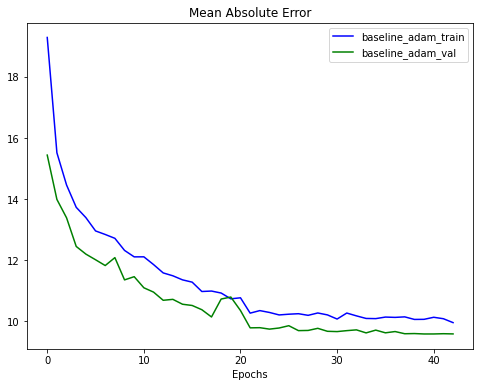

In [33]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train", color="blue")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '-', label=cond+"_val", color="green")
plt.title("Mean Absolute Error")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Results on Test Set
#### Loss: 9.50348114113819
#### Mean Absolute Error: 9.503398895263672

In [45]:
model_test_results = model.evaluate(X_test, y_test, batch_size=128)
dict(zip(model.metrics_names, model_test_results))

2933/2933 [==============================] - 12s 4ms/step


{'loss': 9.50348114113819, 'mean_absolute_error': 9.503398895263672}

In [52]:
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if(y_pred[i][0]<0):
        y_pred[i][0]=0
y_pred = np.around(y_pred, decimals=0).astype(int)


In [56]:
np.sum(np.equal(y_test, y_pred))/np.size(y_test)

36.03784520968292